In [16]:
!pip install pymde emblaze

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 73.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 10.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 17.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 19.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 8.4 MB/s eta 0:00:00:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 16.0 MB/s eta 0:00:0

In [1]:
import pandas as pd

df = pd.read_parquet('./work/data/hiscore_updates.parquet')

# retain only rows where mode=0
df = df[df['mode'] == 0]

# retain only rows where pp>=75
df = df[df['pp'] >= 75]

# drop columns:
# - mode
# - rank
# - is_classic
df = df.drop(columns=['mode', 'rank', 'is_classic'])

# convert types:
# user -> int32
# pp -> f32
# mods -> int32
df['user'] = df['user'].astype('int32')
df['pp'] = df['pp'].astype('float32')
df['mods'] = df['mods'].astype('int32')

print(f"Retained: {len(df)}")

df.head()

Retained: 30587537


,user,beatmap_id,score,pp,mods,score_time,update_time
275,55,48067,1631540,85.583900,0,2013-03-23 03:22:26,2022-11-20 15:17:13
276,55,48067,1631540,86.331703,0,2013-03-23 11:22:26,2017-02-01 13:30:30
278,55,116876,3484018,86.219597,0,2013-05-20 13:54:29,2022-11-20 15:17:13
279,55,116876,3484018,82.921402,0,2013-05-20 21:54:29,2017-02-01 13:30:30
280,55,102891,4221594,87.754799,0,2013-05-21 13:05:41,2022-11-20 15:17:13


In [2]:
"""
We only care about the following mods:
 - DT or NC -> DT
 - HD
 - EZ
 - HR
 - HT
 - FL

And we return them as a concatenated string in alphabetical order (e.g. "DTFLHR")
"""
def decode_mods_bitset(bitset: int):
    mods = ''
    if bitset & (1 << 6):
        mods += 'DT'
    if bitset & (1 << 1):
        mods += 'EZ'
    if bitset & (1 << 10):
        mods += 'FL'
    # if bitset & (1 << 3):
    #     mods += 'HD'
    if bitset & (1 << 4):
        mods += 'HR'
    if bitset & (1 << 8):
        mods += 'HT'

    return mods

# Apply the function to the 'mods' column
df['mods'] = df['mods'].apply(decode_mods_bitset)

In [3]:
df['score_id'] = df['beatmap_id'].astype(str) + '_' + df['mods'].astype(str)

In [4]:
# pre-sort the hiscores df by (user ascending, score_id ascending, update_time descending)
df.sort_values(by=['user', 'score_id', 'update_time'], ascending=[True, True, False], inplace=True)

# retain only the top pp score for each user+score_id
df = df.drop_duplicates(subset=['user', 'score_id'], keep='first')

In [5]:
user_counts = df.groupby('score_id')['user'].nunique()
user_counts.head()

score_id
1000052_DTHR     3
1000075_         3
1000075_DT       1
1000168_        62
1000168_HR       3
Name: user, dtype: int64

In [6]:
# find all unique score IDs by user id=4093752 and dump to csv
user_scores = df[df['user'] == 4093752]
unique_scores = user_scores['score_id'].unique()
unique_scores_df = pd.DataFrame(unique_scores, columns=['score'])
unique_scores_df.to_csv('./work/data/my_score_ids.csv', index=False)

In [7]:
# dump some extra metadata about scores to csv:
#
# - score_id
# - average pp
# - number of unique users

score_metadata = df.groupby('score_id').agg(
    avg_pp=('pp', 'mean'),
    num_users=('user', 'nunique')
).reset_index()

score_metadata.to_csv('./work/data/score_metadata.csv', index=False)

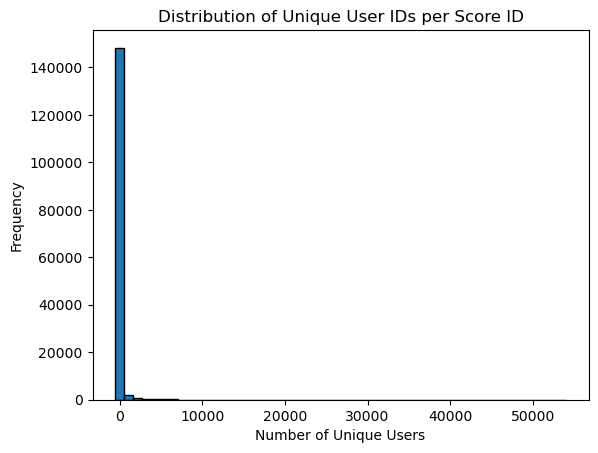

In [8]:
import matplotlib.pyplot as plt

plt.hist(user_counts, bins=50, edgecolor='black', align='left')
plt.title('Distribution of Unique User IDs per Score ID')
plt.xlabel('Number of Unique Users')
plt.ylabel('Frequency')
# plt.xticks(range(1, user_counts.max() + 1))  # Ensure there is a tick for every user count
plt.show()

In [9]:
# Count how many 'score_id' have exactly one unique user
single_user_score_ids = user_counts[user_counts == 1].count()

print(f"Number of 'score_id' with exactly one unique user: {single_user_score_ids}")

two_user_score_ids = user_counts[user_counts == 2].count()

print(f"Number of 'score_id' with exactly two unique users: {two_user_score_ids}")

three_user_score_ids = user_counts[user_counts == 3].count()

print(f"Number of 'score_id' with exactly three unique users: {three_user_score_ids}")

four_user_score_ids = user_counts[user_counts == 4].count()

print(f"Number of 'score_id' with exactly four unique users: {four_user_score_ids}")

# filter out scores with less than 50 users
df = df[df['score_id'].isin(user_counts[user_counts >= 50].index)]

Number of 'score_id' with exactly one unique user: 43566
Number of 'score_id' with exactly two unique users: 17238
Number of 'score_id' with exactly three unique users: 10231
Number of 'score_id' with exactly four unique users: 7130


In [10]:
unique_scores = df['score_id'].unique()

# populate mapping from score id to index in the co-occurrence matrix
score_to_index = {score: i for i, score in enumerate(unique_scores)}

df['score_ix'] = df['score_id'].apply(lambda x: score_to_index[x]).astype('int32')

print(f"Unique score count: {len(unique_scores)}")

Unique score count: 26736


In [11]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix
from numba import jit
import gc

def condense_matrices(main_csr, uniq_score_count, rows, cols, vals):
    coo = coo_matrix((vals, (rows, cols)), shape=(uniq_score_count, uniq_score_count), dtype=np.float32)
    main_csr += coo.tocsr()

    gc.collect()

    return main_csr

chunk_size = 100_000_000

@jit(nopython=True)
def fill_arrays(cur_scores: np.ndarray, cur_scores_pps: np.ndarray, cur_score_ix: int, rows: np.ndarray, cols: np.ndarray, vals: np.ndarray, arr_ix: int) -> int:
    for i in range(cur_score_ix - 1):
        score_i_ix = cur_scores[i]

        for j in range(i + 1, cur_score_ix):
            # compute weight based on relative pp difference
            #
            # 0% difference -> weight = 2
            # 25% difference -> weight = 1
            # 50% difference -> weight = 0
            # >50% difference -> weight = 0
            #
            # decreasing linearly from 1 to 0 as difference increases.  Anything over 50% difference is 0.
            pp_i = cur_scores_pps[i]
            pp_j = cur_scores_pps[j]
            max_pp = max(pp_i, pp_j)
            relative_diff = abs(pp_i - pp_j) / max_pp
            weight = 0 if relative_diff > 0.5 else (1 - (relative_diff / 0.5)) * 2

            if weight <= 0:
                continue

            score_j_ix = cur_scores[j]
            rows[arr_ix] = score_i_ix
            cols[arr_ix] = score_j_ix
            vals[arr_ix] = weight
            arr_ix += 1

            if arr_ix >= chunk_size:
                raise ValueError("Array index out of bounds")

    return arr_ix

def compute_cooccurrence_matrix(uniq_score_count: int, df: pd.DataFrame) -> csr_matrix:
    main_csr = csr_matrix((uniq_score_count, uniq_score_count), dtype=np.float32)

    # collect up chunks of matrix entries
    rows = np.ndarray(chunk_size, dtype=np.int32)
    cols = np.ndarray(chunk_size, dtype=np.int32)
    vals = np.ndarray(chunk_size, dtype=np.float32)
    arr_ix = 0

    cur_user_id = 0
    # re-use typed array for current user's scores
    cur_scores = np.ndarray(50000, dtype=np.int32)
    cur_scores_pps = np.ndarray(50000, dtype=np.float32)
    cur_score_ix = 0

    row_ix = 0
    for row in df.itertuples():
        if row_ix % 2000000 == 0:
            print(f"Processing row {row_ix} of {len(df)}")
            main_csr.sum_duplicates()
            print(f"Main CSR nnz: {main_csr.nnz}")

        user_id = row.user
        score_ix = row.score_ix
        pp = row.pp

        if cur_user_id != user_id:
            needed_space = (cur_score_ix * (cur_score_ix - 1)) // 2
            if needed_space + arr_ix >= chunk_size:
                main_csr = condense_matrices(main_csr, uniq_score_count, rows[:arr_ix], cols[:arr_ix], vals[:arr_ix])
                arr_ix = 0

            arr_ix = fill_arrays(cur_scores, cur_scores_pps, cur_score_ix, rows, cols, vals, arr_ix)

            cur_user_id = user_id
            cur_scores[0] = score_ix
            cur_scores_pps[0] = pp
            cur_score_ix = 1
        else:
            cur_scores[cur_score_ix] = score_ix
            cur_scores_pps[cur_score_ix] = pp
            cur_score_ix += 1

        row_ix += 1

    print(f"final main CSR nnz: {main_csr.nnz}")

    return main_csr

In [12]:
cooccurrence_matrix = compute_cooccurrence_matrix(len(unique_scores), df)

Processing row 0 of 24667822
Main CSR nnz: 0
Processing row 2000000 of 24667822
Main CSR nnz: 26360587
Processing row 4000000 of 24667822
Main CSR nnz: 52267431
Processing row 6000000 of 24667822
Main CSR nnz: 63208363
Processing row 8000000 of 24667822
Main CSR nnz: 72327118
Processing row 10000000 of 24667822
Main CSR nnz: 80267995
Processing row 12000000 of 24667822
Main CSR nnz: 87545357
Processing row 14000000 of 24667822
Main CSR nnz: 97519907
Processing row 16000000 of 24667822
Main CSR nnz: 104218250
Processing row 18000000 of 24667822
Main CSR nnz: 111079706
Processing row 20000000 of 24667822
Main CSR nnz: 118065490
Processing row 22000000 of 24667822
Main CSR nnz: 121346542
Processing row 24000000 of 24667822
Main CSR nnz: 127206497
final main CSR nnz: 130192141


In [13]:
# symmetrize
sym_cooccurrence_matrix = (cooccurrence_matrix + cooccurrence_matrix.transpose()).tocsr()
print(f"Symmetrized co-occurrence matrix nnz: {sym_cooccurrence_matrix.nnz}")

Symmetrized co-occurrence matrix nnz: 260384282


In [192]:
# Now, we want to sparsify the matrix further by retaining only the top n co-occurrences for each score_id
#
# Since we've already symmetrized the matrix, we can just iterate over the rows, retain the top n co-occurrences,
# and build a new sparse matrix from that.  We also trim out any low-count co-occurrences.
#
# While we're at it, we also need to map the values from co-occurrence counts to a distance metric such that
# higher counts are closer to 0. We'll use the following formula:
#
# distance = 1 / log(count)

rows, cols, data = [], [], []

topn = 500
for row_ix in range(sym_cooccurrence_matrix.shape[0]):
    if row_ix % 1000 == 0:
        print(f"Processing row {row_ix} of {sym_cooccurrence_matrix.shape[0]}")

    row = sym_cooccurrence_matrix.getrow(row_ix)
    top_indices = np.argsort(row.data)[-topn:]
    # filter out low-count co-occurrences
    top_indices = top_indices[row.data[top_indices] > 2]
    rows.extend([row_ix] * len(top_indices))
    cols.extend(row.indices[top_indices])
    # mapped_data = -np.log(row.data[top_indices] / row.data.sum())
    mapped_data = np.reciprocal(np.log(row.data[top_indices]))
    data.extend(mapped_data)
    # data.extend(row.data[top_indices])
    # data.extend(np.ones(len(top_indices), dtype=np.float32))

top_cooccurrence_matrix = csr_matrix((data, (rows, cols)), shape=sym_cooccurrence_matrix.shape, dtype=np.float32)
print(f"Top co-occurrence matrix nnz: {top_cooccurrence_matrix.nnz}")

Processing row 0 of 26736
Processing row 1000 of 26736
Processing row 2000 of 26736
Processing row 3000 of 26736
Processing row 4000 of 26736
Processing row 5000 of 26736
Processing row 6000 of 26736
Processing row 7000 of 26736
Processing row 8000 of 26736
Processing row 9000 of 26736
Processing row 10000 of 26736
Processing row 11000 of 26736
Processing row 12000 of 26736
Processing row 13000 of 26736
Processing row 14000 of 26736
Processing row 15000 of 26736
Processing row 16000 of 26736
Processing row 17000 of 26736
Processing row 18000 of 26736
Processing row 19000 of 26736
Processing row 20000 of 26736
Processing row 21000 of 26736
Processing row 22000 of 26736
Processing row 23000 of 26736
Processing row 24000 of 26736
Processing row 25000 of 26736
Processing row 26000 of 26736
Top co-occurrence matrix nnz: 13367525


In [193]:
import pymde

import numpy as np
import matplotlib.pyplot as plt

cooccurrence_graph = pymde.preprocess.Graph(top_cooccurrence_matrix)

In [14]:
shortest_path_graph = pymde.preprocess.graph.shortest_paths(cooccurrence_graph, verbose=True, n_workers=30)

Apr 22 10:31:52 AM: Computing shortest path distances (retaining 100.00 percent with max_distance=None) ...
Apr 22 10:31:52 AM: Graph is weighted ... using slow path.
Apr 22 10:31:55 AM: processed node 1/43831
Apr 22 10:32:00 AM: processed node 4384/43831
Apr 22 10:32:05 AM: processed node 8767/43831
Apr 22 10:32:11 AM: processed node 13150/43831
Apr 22 10:32:16 AM: processed node 17533/43831
Apr 22 10:32:21 AM: processed node 21916/43831
Apr 22 10:32:26 AM: processed node 26299/43831
Apr 22 10:32:31 AM: processed node 30682/43831
Apr 22 10:32:36 AM: processed node 35065/43831
Apr 22 10:32:42 AM: processed node 39448/43831
Apr 22 10:32:47 AM: processed node 43831/43831


In [194]:
n_neighbors = 18
embedding_dim = 3

mde = pymde.preserve_neighbors(
    cooccurrence_graph,
    # shortest_path_graph,
    embedding_dim=embedding_dim,
    attractive_penalty=pymde.penalties.Linear,
    # repulsive_penalty=None,
    verbose=True,
    # max_distance=1.2,
    n_neighbors=n_neighbors,
    init="random",
    # device='cuda'
)

# we do it manually
#
# 1. convert `top_cooccurrence_matrix` to an edge list as a torch tensor with shape (n_edges, 2) and
#    a corresponding edge weight tensor with shape (n_edges,)

# row_list, col_list = top_cooccurrence_matrix.nonzero()
# edge_list = np.stack([row_list, col_list], axis=1)
# edge_weights = top_cooccurrence_matrix.data

# # 2. Construct the distortion function
# distortion_fn = pymde.penalties.Log1p(edge_weights)

# # 3. Impose a centered constraint
# constraint = pymde.constraints.Centered()

# # 4. Construct the MDE instance
# mde = pymde.MDE(
#     n_items=top_cooccurrence_matrix.shape[0],
#     embedding_dim=embedding_dim,
#     edges=edge_list,
#     distortion_function=distortion_fn,
#     constraint=constraint,
#     device='cpu'
# )

Apr 22 10:15:51 PM: Computing 18-nearest neighbors, with max_distance=0.9585261940956116
Apr 22 10:15:51 PM: Computing shortest path distances (retaining 100.00 percent with max_distance=0.9585261940956116) ...
Apr 22 10:15:51 PM: Graph is weighted ... using slow path.
Apr 22 10:15:56 PM: processed node 1/26736
Apr 22 10:16:19 PM: processed node 2674/26736
Apr 22 10:16:41 PM: processed node 5347/26736
Apr 22 10:17:03 PM: processed node 8020/26736
Apr 22 10:17:25 PM: processed node 10693/26736
Apr 22 10:17:47 PM: processed node 13366/26736
Apr 22 10:18:09 PM: processed node 16039/26736
Apr 22 10:18:32 PM: processed node 18712/26736
Apr 22 10:18:53 PM: processed node 21385/26736
Apr 22 10:19:15 PM: processed node 24058/26736
Apr 22 10:19:37 PM: processed node 26731/26736


In [195]:
embedding = mde.embed(verbose=True, max_iter=2000, print_every=50)

Apr 22 10:20:11 PM: Fitting a centered embedding into R^3, for a graph with 26736 items and 929093 edges.
Apr 22 10:20:11 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Apr 22 10:20:11 PM: iteration 0000 | distortion 1.260675 | residual norm 0.0120257 | step length 983.631 | percent change 4.18201
Apr 22 10:20:14 PM: iteration 0050 | distortion 0.550411 | residual norm 0.00339066 | step length 1 | percent change 4.11404
Apr 22 10:20:16 PM: iteration 0100 | distortion 0.371344 | residual norm 0.00263752 | step length 1 | percent change 0.542382
Apr 22 10:20:18 PM: iteration 0150 | distortion 0.330300 | residual norm 0.00110773 | step length 1 | percent change 0.621139
Apr 22 10:20:20 PM: iteration 0200 | distortion 0.323424 | residual norm 0.000587722 | step length 1 | percent change 0.181312
Apr 22 10:20:22 PM: iteration 0250 | distortion 0.322506 | residual norm 0.000552015 | step length 1 | percent change 0.0878475
Apr 22 10:20:24 PM: iteration 0300 | disto

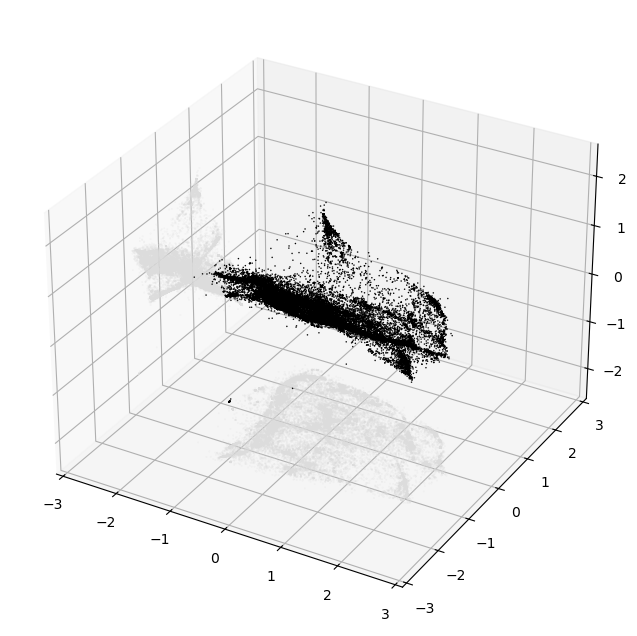

In [196]:
mde.plot(colors=['black'])
# plot from x=-3 to 3
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

In [197]:
# export in w2v format
fname = f'./work/data/pymde_{embedding_dim}d_{n_neighbors}n.w2v'
with open(fname, 'wt') as f:
    # write header
    f.write('{} {}\n'.format(len(embedding), mde.embedding_dim))
    for i in range(len(embedding)):
        row = embedding[i].tolist()
        f.write('{} {}\n'.format(i, ' '.join(map(str, row))))
fname

'./work/data/pymde_3d_18n.w2v'

In [198]:
# write dataframe mapping score_id to index
mapping = [(score_id, i) for score_id, i in score_to_index.items()]
mapping_df = pd.DataFrame(mapping, columns=['score_id', 'index'])
mapping_df.to_csv(f'{fname}.csv', index=False)
mapping_df.head()

# code to load:
# mapping_df = pd.read_csv('./work/data/score_id_mapping.csv')
# score_id_by_ix = mapping_df.set_index('index')['score_id'].to_dict()

,score_id,index
0,1007525_,0
1,1057659_,1
2,1089041_,2
3,109479_,3
4,112583_,4
